## BigDL Wide & Deep Recommender Demo

Wide and Deep Learning Model, proposed by Google in 2016, is a DNN-Linear mixed model. Wide and deep learning has been used for Google App Store for their app recommendation.

In this tutorial, we'll introduce how to use BigDL to train a wide linear model and a deep neural network, which is called Wide & Deep model. Wide & Deep model combines the strength of memorization and generalization. It's useful for generic large-scale regression and classification problems with sparse input features(e.g., categorical features with a large number of possible feature values).

In [1]:
#%pylab inline

import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import datetime as dt

from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *

redire_spark_logs()
show_bigdl_info_logs()
init_engine()

Using /Users/lizhichao/bin/spark-1.6.3-bin-hadoop2.6
Adding /Users/lizhichao/anaconda/envs/bigdl04py27/lib/python2.7/site-packages/bigdl/share/lib/bigdl-0.5.0-SNAPSHOT-jar-with-dependencies.jar to BIGDL_JARS
Prepending /Users/lizhichao/anaconda/envs/bigdl04py27/lib/python2.7/site-packages/bigdl/share/conf/spark-bigdl.conf to sys.path
Adding /Users/lizhichao/anaconda/envs/bigdl04py27/lib/python2.7/site-packages/bigdl/share/lib/bigdl-0.5.0-SNAPSHOT-jar-with-dependencies.jar to SPARK_CLASSPATH


In [14]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

NUM_COLUMNS=15

LABEL_COLUMN = "label"

AGE, WORKCLASS, FNLWGT, EDUCATION, EDUCATION_NUM, MARITAL_STATUS, OCCUPATION, \
RELATIONSHIP, RACE, GENDER, CAPITAL_GAIN, CAPITAL_LOSS, HOURS_PER_WEEK, NATIVE_COUNTRY, \
LABEL = range(NUM_COLUMNS)

EDUCATION_VOCAB = ["Bachelors", "HS-grad", "11th", "Masters", "9th",
  "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
  "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
  "Preschool", "12th"] # 16
MARITAL_STATUS_VOCAB = ["Married-civ-spouse", "Divorced", "Married-spouse-absent",
    "Never-married", "Separated", "Married-AF-spouse", "Widowed"]
RELATIONSHIP_VOCAB = ["Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
    "Other-relative"]  # 6
WORKCLASS_VOCAB = ["Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
    "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"] # 9
GENDER_VOCAB = ["Female", "Male"]
AGE_BOUNDARIES = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65]

def hashbucket(sth, bucketsize = 1000, start = 0):
    return (id(sth) % bucketsize + bucketsize) % bucketsize + start

def categorical_from_vocab_list(sth, vocab_list, default = -1, start = 0):
    if sth in vocab_list:
        return vocab_list.index(sth) + start
    else:
        return default + start
    
def get_boundaries(numage, boundaries, default = -1, start = 0):
    if numage == '?':
        return default + start
    else:
        for i in range(len(boundaries)):
            if numage < boundaries[i]:
                return i + start
        return len(boundaries) + start
    
def get_label(label):
    if label == ">50K" or label == ">50K.":
        return 2
    else:
        return 1
    
def read(file, sc):
    lines=sc.textFile(file).map(lambda line: list(map(lambda word: word.strip(), line.split(',')))).filter(lambda line: len(line) == NUM_COLUMNS)
    return lines

## 1. Prepare Data
Download training and testing data set from [Census Income Dataset](https://archive.ics.uci.edu/ml/datasets/Census+Income).
Read and parse the dataset into Spark RDD.

In [15]:
from bigdl.dataset.base import maybe_download
from bigdl.util.common import get_spark_context
sc = get_spark_context()
train_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
test_file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test'

absolutepath='file://' + os.getcwd() + '/'
train_file_name = maybe_download('adult.data', 'census_dataset', train_file_url)
test_file_name = maybe_download('adult.test', 'census_dataset', test_file_url)

train_records = read(absolutepath + train_file_name, sc)
test_records = read(absolutepath + test_file_name, sc)


Training data set has 14 features age, workclass, fnlwgt, etc... and one label income_bracket. There is ten record of the dataset.

In [11]:
pd.DataFrame(train_records.take(4), columns=COLUMNS)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,gender,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K


In [16]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

NUM_COLUMNS=15

LABEL_COLUMN = "label"

AGE, WORKCLASS, FNLWGT, EDUCATION, EDUCATION_NUM, MARITAL_STATUS, OCCUPATION, \
RELATIONSHIP, RACE, GENDER, CAPITAL_GAIN, CAPITAL_LOSS, HOURS_PER_WEEK, NATIVE_COUNTRY, \
LABEL = range(NUM_COLUMNS)

EDUCATION_VOCAB = ["Bachelors", "HS-grad", "11th", "Masters", "9th",
  "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
  "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
  "Preschool", "12th"] # 16
MARITAL_STATUS_VOCAB = ["Married-civ-spouse", "Divorced", "Married-spouse-absent",
    "Never-married", "Separated", "Married-AF-spouse", "Widowed"]
RELATIONSHIP_VOCAB = ["Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
    "Other-relative"]  # 6
WORKCLASS_VOCAB = ["Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
    "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"] # 9
GENDER_VOCAB = ["Female", "Male"]
AGE_BOUNDARIES = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65]

def hashbucket(sth, bucketsize = 1000):
    return (id(sth) % bucketsize + bucketsize) % bucketsize

def categorical_from_vocab_list(sth, vocab_list, default = 0):
    if sth in vocab_list:
        return vocab_list.index(sth)
    else:
        return default
    
def get_boundaries(numage, boundaries, default = 0):
    if numage == '?':
        return default
    else:
        for i in range(len(boundaries)):
            if numage < boundaries[i]:
                return i
        return len(boundaries)
    
def get_label(label):
    if label == ">50K" or label == ">50K.":
        return 2
    else:
        return 1
    
def read(file, sc):
    lines=sc.textFile(file).map(lambda line: list(map(lambda word: word.strip(), line.split(',')))).filter(lambda line: len(line) == NUM_COLUMNS)
    return lines

def one_hot(index, nb_classes):
    #return np.eye(nb_classes)[np.array(targets).reshape(-1)]
    a = np.zeros(nb_classes)
    np.put(a, index , 1)
    return a

## 2. Transform data to BigDL' Sample
BigDL's Sample is a data structure who represents the features and label of data. So each record will be transform to a BigDL Sample, and BigDL will train the Wide&Deep with these Samples. 

The input BigDL Wide&Deep model required,  are two input tensors, one is SparseTensor for the Wide model, another is a DenseTensor for the Deep model.

In [23]:
def to_sample(row):    
    gender = categorical_from_vocab_list(row[GENDER], GENDER_VOCAB)

    education = categorical_from_vocab_list(row[EDUCATION], EDUCATION_VOCAB)
        
    marital_status = categorical_from_vocab_list(row[MARITAL_STATUS], MARITAL_STATUS_VOCAB)
    
    relationship = categorical_from_vocab_list(row[RELATIONSHIP], RELATIONSHIP_VOCAB)

    workclass = categorical_from_vocab_list(row[WORKCLASS], WORKCLASS_VOCAB)


    wide_input = np.concatenate([np.array(gender).reshape([1]),
                                 np.array(education).reshape([1]),
                                 np.array(marital_status).reshape([1]),
                                 np.array(relationship).reshape([1]),
                                 np.array(workclass).reshape([1]),
                                 one_hot(hashbucket(row[OCCUPATION], 1000), 1000),
                                 one_hot(hashbucket(row[NATIVE_COUNTRY], 1000), 1000),
                                 np.array(get_boundaries(int(row[AGE]), AGE_BOUNDARIES)).reshape([1]),
                                 one_hot(hashbucket(row[EDUCATION] + row[OCCUPATION], 1000), 1000),
                                 one_hot(hashbucket(str(row[AGE]) + row[EDUCATION] + row[OCCUPATION], 1000), 1000),
                                 one_hot(hashbucket(row[NATIVE_COUNTRY] + row[OCCUPATION], 1000), 1000)], axis=0)

    deep_column_indicator = np.zeros(33)
    
    deep_column_indicator[workclass] = 1  ## total 9 workclass
    deep_column_indicator[education + 9] = 1 ## total 16 education
    deep_column_indicator[gender + 25] = 1
    deep_column_indicator[relationship + 27] = 1
    
    deep_column_embedding_1 = np.zeros(1)
    deep_column_embedding_1[0] = hashbucket(row[NATIVE_COUNTRY], 1000) + 1 # label in bigdl is one-based
    
    deep_column_embedding_2 = np.zeros(1)
    deep_column_embedding_2[0] = hashbucket(row[OCCUPATION], 1000) + 1
    
    deep_column_numeric = np.zeros(2)

    deep_column_numeric[0] = row[AGE]
    deep_column_numeric[1] = row[EDUCATION_NUM]
#     deep_column_numeric[2] = row[CAPITAL_GAIN]
#     deep_column_numeric[3] = row[CAPITAL_LOSS]
#     deep_column_numeric[4] = row[HOURS_PER_WEEK]
    
    label = get_label(row[LABEL])

    wide_input = JTensor.from_ndarray(wide_input.squeeze())
    deep_column_indicator = JTensor.from_ndarray(deep_column_indicator.reshape([33]))
    deep_column_embedding_1 = JTensor.from_ndarray(deep_column_embedding_1.reshape([1]))
    deep_column_embedding_2 = JTensor.from_ndarray(deep_column_embedding_2.reshape([1]))
    deep_column_numeric = JTensor.from_ndarray(deep_column_numeric)

    return Sample.from_jtensor([wide_input, deep_column_indicator, deep_column_embedding_1, deep_column_embedding_2, deep_column_numeric], label)

    
#print(to_sample(train_records.first())[1].shape)
train_data = train_records.map(lambda line: to_sample(line))
test_data = test_records.map(lambda line: to_sample(line))
train_data.first().features[0]

train_data.cache()
print "Total train records: %s" % train_data.count()
test_data.cache()
print "Total test records: %s" % test_data.count()
print train_data.first().features[0]


Total train records: 32561
Total test records: 16281
JTensor: storage: [ 1.  0.  3. ...,  0.  0.  0.], shape: [5006], float


Cache the Training and Testing data RDD.

## 3. Create the Wide&Deep model.

In [24]:
def build_model(class_num = 2):
#     from bigdl.nn.keras.topology import Model, Sequential
#     from bigdl.nn.keras.layer import *
    from keras.layers import *
    from keras.engine import *
    wide_in = Input(shape=[5006])
    deep_indicator_input = Input(shape=[33])
    deep_embedding_1_input = Input(shape=[1])
    deep_embedding_2_input = Input(shape=[1])

    e1 = deep_embedding_1_input
    deep_embedding_1 = Reshape([8])(Embedding(1000, 8, input_shape=[1])(e1))

    e2 = deep_embedding_2_input
    deep_embedding_2 = Reshape([8])(Embedding(1000, 8, input_shape=[1])(e2))
    
    deep_numerics_input = Input(shape=[2])
    deep_out = merge(inputs=[deep_indicator_input, deep_embedding_1, deep_embedding_2, deep_numerics_input], mode="concat", concat_axis=1)
#     deep_out = merge(inputs=[deep_embedding_1, deep_embedding_2], mode="concat", concat_axis=1)

    deep_fc_1 = Dense(100, activation = "relu", name="fc_1")(deep_out)
    deep_fc_2 = Dense(50, activation = "relu", name="fc_2")(deep_fc_1)
    w_n_d_out = merge(inputs=[wide_in, deep_fc_2], mode="concat", concat_axis=1)
     
    linear_out = Dense(class_num, name="fc_3")(w_n_d_out)
    final_out = Activation("softmax")(linear_out)
    deepModel = Model([wide_in, deep_indicator_input, deep_embedding_1_input, deep_embedding_2_input, deep_numerics_input], final_out)
#     deepModel = Model([wide_in, deep_embedding_1_input, deep_embedding_2_input], final_out)
    return deepModel


wide_n_deep_keras=build_model()


<ipython-input-24-d2fc9767c921>:1: SyntaxWarning: import * only allowed at module level
  def build_model(class_num = 2):
<ipython-input-24-d2fc9767c921>:1: SyntaxWarning: import * only allowed at module level
  def build_model(class_num = 2):


In [8]:
! pip install pydot-ng
! pip install graphviz
! brew install graphviz  # change to apt-get install graphviz
import pydot

You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 9.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Updating Homebrew...
==> Installing dependencies for graphviz: libtool, freetype, fontconfig, webp, gd
==> Installing graphviz dependency: libtool
==> Downloading https://mirrors.ustc.edu.cn/homebrew-bottles/bottles/libtool-2.4
######################################################################## 100.0%
==> Pouring libtool-2.4.6_1.sierra.bottle.tar.gz
==> Caveats
In order to prevent conflicts with Apple's own libtool we have prepended a "g"
so, you have instead: glibtool and glibtoolize.
==> Summary
🍺  /usr/local/Cellar/libtool/2.4.6_1: 70 files, 3.7MB
==> Installing graphviz dependency: freetype
==> Downloading https://mirrors.ustc.edu.cn/homebrew-bottles/bottles/freetype-2.
==> Downloading from htt

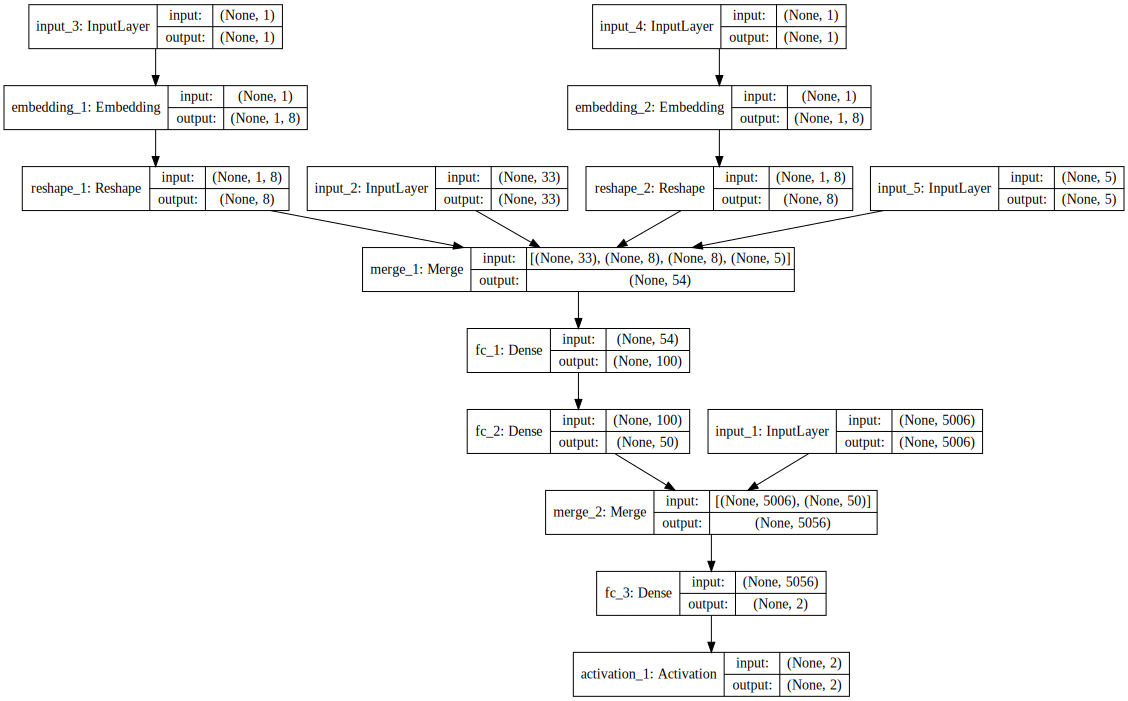

In [10]:

from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(wide_n_deep_keras, show_shapes=True).create(prog='dot', format='svg'))

In [25]:
from bigdl.keras.backend import *

# Load a Keras definition
bmodel = DefinitionLoader.from_kmodel(wide_n_deep_keras)
# Dump weights from kears model to BigDL
WeightLoader.load_weights_from_kmodel(bmodel, wide_n_deep_keras)

wide_n_deep = bmodel
#print "Wide&Deep model:\n %s" % wide_n_deep  TODO: save and show this model via tensorboard

creating: createInput
creating: createInput
creating: createSequential
creating: createLookupTable
creating: createAddConstant
creating: createRandomUniform
creating: createSequential
creating: createLookupTable
creating: createAddConstant
creating: createRandomUniform
creating: createInput
creating: createReshape
creating: createReshape
creating: createInput
creating: createJoinTable
creating: createLinear
creating: createXavier
creating: createZeros
creating: createReLU
creating: createSequential
creating: createInput
creating: createLinear
creating: createXavier
creating: createZeros
creating: createReLU
creating: createSequential
creating: createJoinTable
creating: createLinear
creating: createXavier
creating: createZeros
creating: createSoftMax
creating: createModel


## 4. Create optimizer and training the model

In [29]:

batch_size = 2048
optimizer = Optimizer(
    model=bmodel,
    training_rdd=train_data,
    criterion=ClassNLLCriterion(logProbAsInput=False),
    optim_method= Adam(learningrate = 0.001, learningrate_decay=0.00005),
    end_trigger=MaxEpoch(40),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=test_data,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy(), Loss()]
)
log_dir='/tmp/bigdl_summaries/'
app_name='wide_n_deep-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir=log_dir,
                                     app_name=app_name)
val_summary = ValidationSummary(log_dir=log_dir,
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to %s" % (log_dir + app_name)
optimizer.optimize()

creating: createClassNLLCriterion
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createClassNLLCriterion
creating: createLoss
creating: createTrainSummary
creating: createValidationSummary
saving logs to /tmp/bigdl_summaries/wide_n_deep-20180404-094518


Train the network. Wait some time till it finished.. Voila! You've got a trained model

## 5. Evaluate the trained model
Will return a Top1 Accuracy about 84%.

In [31]:
%%time
#evaluate_result=wide_n_deep.evaluate(test_data) # !!NOTE there's bug here that you need to invoke "compile" before calling this method.
evaluate_result=wide_n_deep.evaluate(test_data, 2, [Top1Accuracy()])
print "Top1 accuracy: %s" % evaluate_result[0].result

creating: createTop1Accuracy
Top1 accuracy: 0.825686395168
CPU times: user 4.18 ms, sys: 2.56 ms, total: 6.74 ms
Wall time: 2.19 s


## 6. Draw the convergence curve

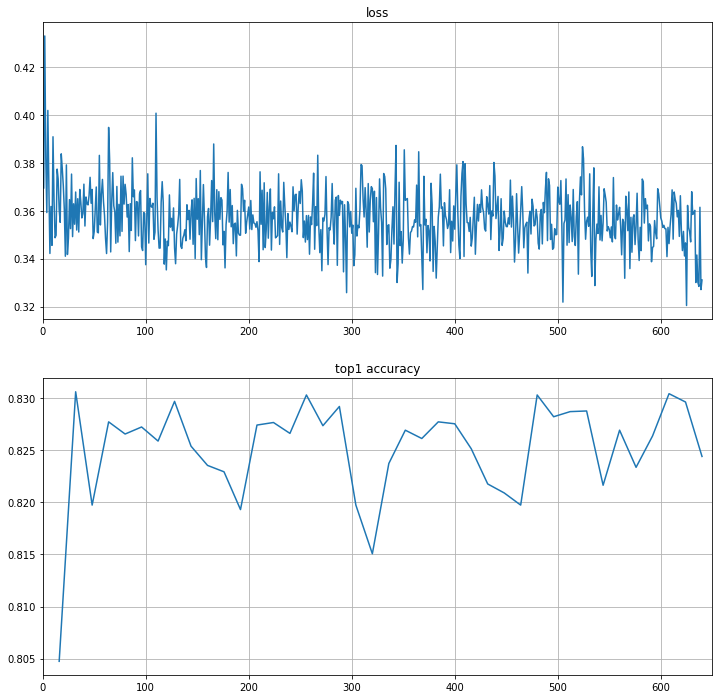

In [30]:
from matplotlib import pyplot as plt

loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)
plt.show()